In [1]:
# do imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import xlwings as xl
import datetime as dt

#plt.style.use('tableau-colorblind10')
#plt.style.available

In [2]:
#do web pulls. 

# 14 day data table
url = 'https://www.ecdc.europa.eu/en/cases-2019-ncov-eueea'
df = pd.read_html(url,header=0)[0]

# 14 day data table-pull html to get the title
html = requests.get(url)
soup = BeautifulSoup(html.content)

# pull timeseries data
url='https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'
data_raw = pd.read_excel(url)

# pull the weekly subnational data - do not have a "latest" file so need to change the date 
# Check https://www.ecdc.europa.eu/en/publications-data/weekly-subnational-14-day-notification-rate-covid-19 for the latest file
# Spain isn't in the daily regional data 
url='https://www.ecdc.europa.eu/sites/default/files/documents/subnational_weekly_data_2020-08-26.xlsx'
data_subnational = pd.read_excel(url)



In [3]:
# data processing
# do some preprocessing. Rename columns on the table and select the right columns and put in new dataframes
# data  is the cutdown table from the webpage (cut off the bottom row which it at total)
# series is the timeseries cutdown

new_df = df.rename(columns = {'EU/EEA and the UK':'Country','14-day cumulative number of COVID-19 cases per 100 000' : 'rate'})
data =  new_df[['Country','rate']][:-1]
data = data.sort_values('rate')
series = data_raw[['dateRep','countriesAndTerritories','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']]

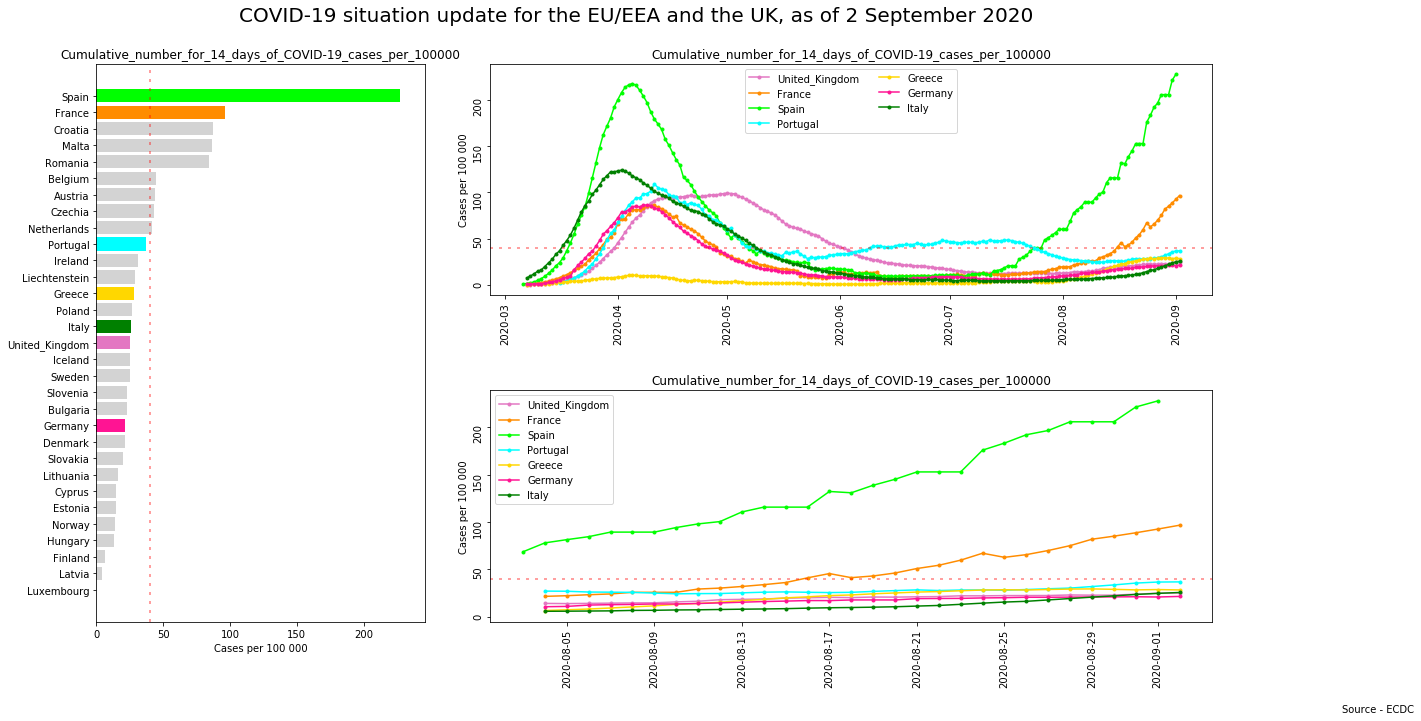

In [4]:
# produce the graphs at a country level 14 day window from the calculated data from ECDC

#set the colours and define the countries of interest
interesting_countries = ['United_Kingdom','France','Spain','Portugal','Greece','Germany','Italy']
country_colours = ['tab:pink','darkorange','lime','aqua', 'gold','deeppink','g']
default_colour = 'lightgrey'
days_back = 180
days_back_short = 30

# can also set the colours as tableau colours for the countries of interest.... https://matplotlib.org/3.1.0/gallery/color/named_colors.html
#country_colours = ['tab:red','tab:orange','tab:green','tab:blue', 'tab:purple','tab:brown','tab:cyan']
# default_colour = 'tab:grey'

# Asign the colours in the table 
data['colour'] = default_colour   # default colour for bars
for i in range(len(interesting_countries)):
    data.loc[data['Country']==interesting_countries[i],['colour']] = country_colours[i]

#------plot 2 graphs - one bar chart by country and then the timeseries for selected countries-----
#Set up the template and set title from the webpage title
fig = plt.figure(figsize=(20, 10))
fig.suptitle(soup.title.string,fontsize=20)
fig.subplots_adjust(top=0.90)
fig.text(0.99,0,'Source - ECDC',fontsize = 10)


#set up the positions of the axes
ax0 = plt.subplot2grid((7, 3), (0, 0),rowspan=7)
ax1 = plt.subplot2grid((7, 3), (0, 1),rowspan=3,colspan=2)
ax2 = plt.subplot2grid((7, 3), (4, 1),rowspan=3,colspan=2)


#bar chart ax0
ax0.set(Title ='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000')
x = ax0.barh(data['Country'],data['rate'],tick_label=data['Country'],color =data['colour'])
ax0.axvline(40,dashes=(2,4),color="r",alpha=0.5)
ax0.set_xlim(left=0)
xlabel = ax0.set_xlabel('Cases per 100 000')

#time series ax[1] loop through the countries of interest
ax1.set(Title ='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000')
for country in interesting_countries:
    ax1.plot(series[series['countriesAndTerritories']==country][:days_back ]['dateRep'],
               series[series['countriesAndTerritories']==country][:days_back ]['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
               '.-',
               color = data[data['Country']==country]['colour'].values[0],
               label= country)
legend = ax1.legend(loc=9,ncol=2, prop={'size': 10})
ax1.axhline(40,dashes=(2,4),color="r",alpha=0.5)
ax1.tick_params(labelrotation=90)
ylabel = ax1.set_ylabel('Cases per 100 000')

#time series ax[2] loop through the countries of interest. Shorter time window
ax2.set(Title ='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000')
for country in interesting_countries:
    ax2.plot(series[series['countriesAndTerritories']==country][:days_back_short ]['dateRep'],
               series[series['countriesAndTerritories']==country][:days_back_short ]['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
               '.-',
               color = data[data['Country']==country]['colour'].values[0],
               label= country)
legend = ax2.legend(loc=2, prop={'size': 10})
ax2.axhline(40,dashes=(2,4),color="r",alpha=0.5)
ax2.tick_params(labelrotation=90)
ylabel = ax2.set_ylabel('Cases per 100 000')


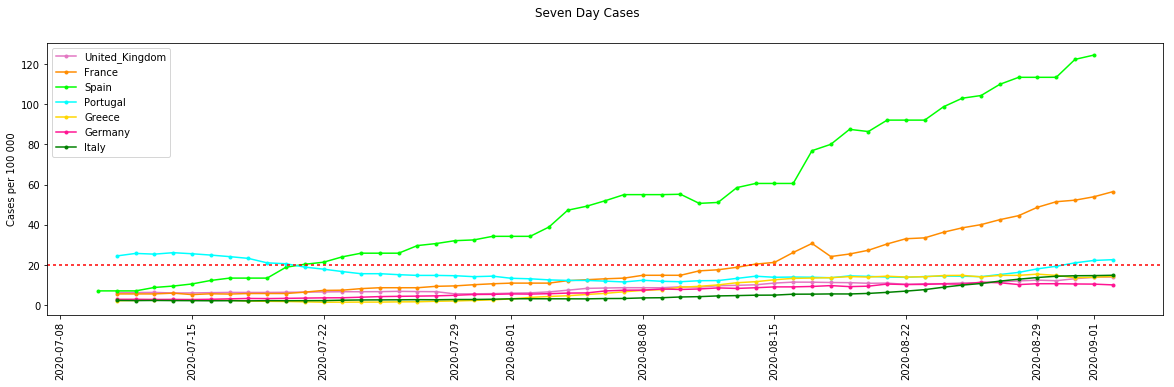

In [24]:
# Need to go back to the raw data to get the 7 day averages

days_back = 60

#time series ax[1] loop through the countries of interest
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.suptitle("Seven Day Cases")
for country in interesting_countries:
    ax.plot(data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['dateRep'],
               data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['cases'].rolling(window=7).sum().shift(-6)/
               data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['popData2019']*100000,
               '.-',
                label= country,
                color=data[data['Country']==country]['colour'].values[0] )
ax.axhline(20,dashes=(2,2),c='r')
legend = ax.legend(loc=2, prop={'size': 10})
plt.setp(plt.xticks()[1], rotation=90)
ylabel = ax.set_ylabel('Cases per 100 000')

In [18]:
#Check the subnational data - can be a bit mixed. 
print(pd.unique(data_subnational["country"]))
print(pd.unique(data_subnational[data_subnational["country"]=="Spain"]["region_name"]))

['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'Ireland' 'Italy' 'Latvia' 'Liechtenstein' 'Lithuania' 'Luxembourg'
 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden' 'United Kingdom']
['Andalucia' 'Aragon' 'Canarias' 'Cantabria' 'Castilla-La Mancha'
 'Castilla Y Leon' 'Cataluna' 'Ciudad Autonoma De Ceuta'
 'Ciudad Autonoma De Melilla' 'Comunidad De Madrid'
 'Comunidad Foral De Navarra' 'Comunidad Valenciana' 'Extremadura'
 'Galicia' 'Illes Balears' 'La Rioja' 'Pais Vasco'
 'Principado De Asturias' 'Region De Murcia']


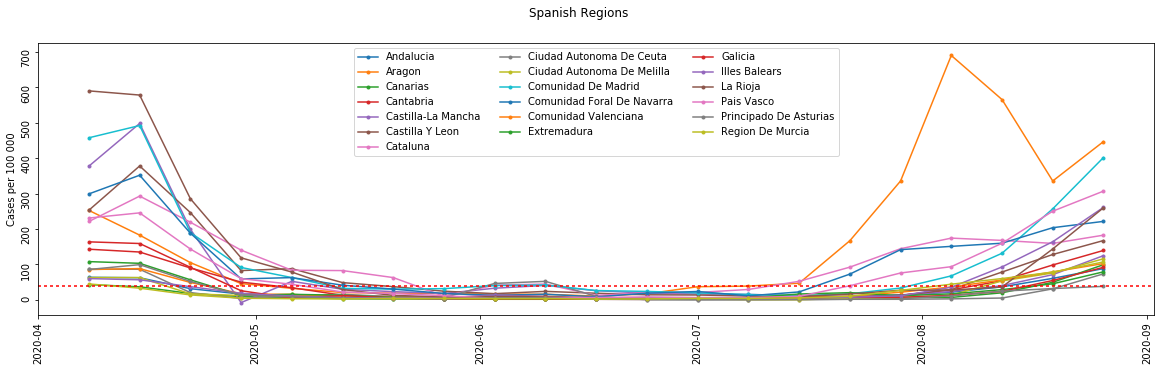

In [19]:
#Plot the subnational data for Spain

#add in the dates 

data_subnational["Date"] = dt.datetime(2020,1,1)+ pd.to_timedelta(data_subnational["year_week"].str[6:8].astype(int)*7,'d')

fig, ax = plt.subplots(1,1, figsize=(20,5))

fig.suptitle("Spanish Regions")
for region in pd.unique(data_subnational[data_subnational["country"]=="Spain"]["region_name"]):
    ax.plot(data_subnational[data_subnational["region_name"]==region]['Date'],
            data_subnational[data_subnational["region_name"]==region]['rate_14_day_per_100k'],
            '.-',
            label= region)
ax.axhline(40,dashes=(2,2),c='r')
legend = ax.legend(loc=9, ncol=3, prop={'size': 10})
ax.tick_params(labelrotation=90)
ylabel = ax.set_ylabel('Cases per 100 000')

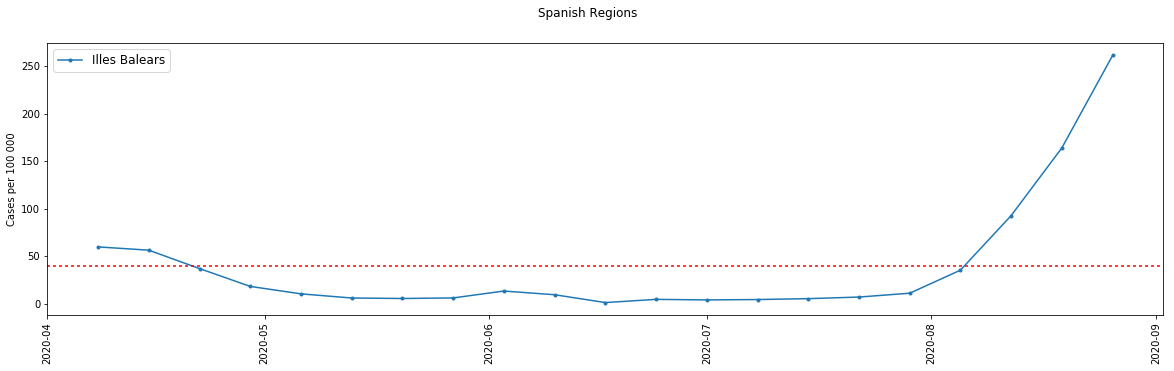

In [20]:
#Individual plot for the Balearics

fig, ax = plt.subplots(1,1, figsize=(20,5))

fig.suptitle("Spanish Regions")
for region in ['Illes Balears']:
    ax.plot(data_subnational[data_subnational["region_name"]==region]['Date'],
            data_subnational[data_subnational["region_name"]==region]['rate_14_day_per_100k'],
            '.-',
            label= region)
ax.axhline(40,dashes=(2,2),c='r')
legend = ax.legend(loc=2, prop={'size': 12})
plt.setp(plt.xticks()[1], rotation=90)
ylabel = ax.set_ylabel('Cases per 100 000')

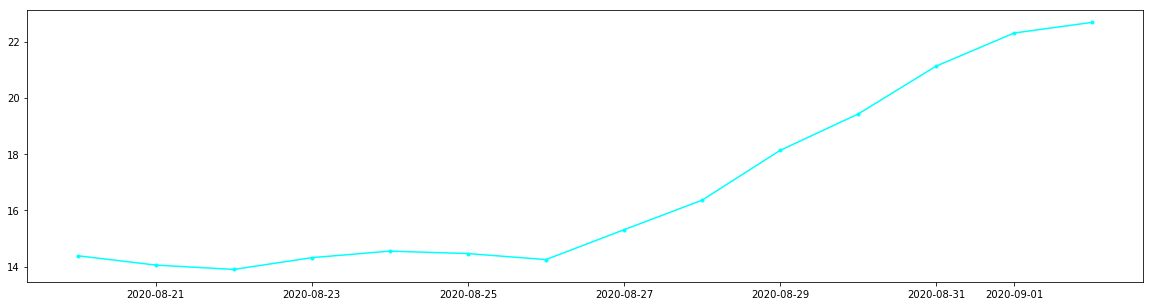

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20,5))

for country in ["Portugal"]:
    ax.plot(data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['dateRep'],
               data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['cases'].rolling(window=7).sum().shift(-6)/
               data_raw[data_raw['countriesAndTerritories']==country][:days_back ]['popData2019']*100000,
               '.-',
                label= country,
                color=data[data['Country']==country]['colour'].values[0] )
